In [20]:
from utilities.preprocessing import TwitterReader
from utilities.preprocessing import extract_emojis,find_mentions,clean_data,stratified_train_eval_test_split
import itertools
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from emoji import EMOJI_DATA
import os
from pathlib import Path
from hparam_tuning import save_best_params,filter_params
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from itertools import product
from utilities.preprocessing import remove_urls
from utilities.dataloading import create_dataloader
from train import train_epoch,train_model,evaluate
from utilities.tokenizers import CharacterTokenizer
from model import TransformerClassifier

In [3]:
#paths
split_folder=Path('./data/split')
hparameter_output_path=Path('output/hparam_result/best_params.json')

In [4]:
#Read in the data
reader=TwitterReader('./data')

all_tweets,labels=reader.get_all_tweets(return_labels=True)
postive_tweets=reader.tweets['positive']
negative_tweets=reader.tweets['negative']
neutral_tweets=reader.tweets['neutral']




**Let's see a few examples per class**

In [5]:
postive_tweets[:10]

["@VirginAmerica plus you've added commercials to the experience... tacky.",
 '@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 "@virginamerica Well, I didn't…but NOW I DO! :-D",
 "@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",
 '@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D',
 "@VirginAmerica This is such a great deal! Already thinking about my 2nd trip to @Australia &amp; I haven't even gone on my 1st trip yet! ;p",
 "@VirginAmerica @virginmedia I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel http://t.co/ahlXHhKiyn",
 '@VirginAmerica Thanks!',
 "@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo",
 'I ❤️ flying @VirginAmerica. ☺️👍']

In [6]:
negative_tweets[:10]

['@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "@VirginAmerica and it's a really big bad thing about it",
 "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.it's really the only bad thing about flying VA",
 '@VirginAmerica SFO-PDX schedule is still MIA.',
 "@VirginAmerica  I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!",
 '@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???',
 '@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet',
 "@VirginAmerica status match program.  I applied and it's been three weeks.  Called and emailed with no response.",
 "@VirginAmerica What happened 2 ur vegan food options?! At least say on ur site

In [7]:
neutral_tweets[:10]

['@VirginAmerica What @dhepburn said.',
 "@VirginAmerica I didn't today... Must mean I need to take another trip!",
 '@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP',
 '@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24',
 '@VirginAmerica will you be making BOS&gt;LAS non stop permanently anytime soon?',
 "@VirginAmerica do you miss me? Don't worry we'll be together very soon.",
 '@VirginAmerica LAX to EWR - Middle seat on a red eye. Such a noob maneuver. #sendambien #andchexmix',
 '@VirginAmerica Are the hours of operation for the Club at SFO that are posted online current?',
 'Nice RT @VirginAmerica: Vibe with the moodlight from takeoff to touchdown. #MoodlitMonday #ScienceBehindTheExperience http://t.co/Y7O0uNxTQP',
 '@VirginAmerica when can I book my flight to Hawaii??']

****Observations:****

We see emojis, urls, mentions

The tweet corresponding to each airline is mostly (but not always) at the very front e.g. **'I ❤️ flying @VirginAmerica. ☺️👍'**

Tweets have varying lengths.

In [8]:
sentiment_dict=reader.sentiment_mapping
label_to_sentiment={v:k for k,v in sentiment_dict.items()}
label_to_sentiment

{0: 'positive', 1: 'negative', 2: 'neutral'}

In [9]:
#Create pandas DataFrames
tweets_df=pd.DataFrame({'tweet':all_tweets,'sentiment':labels})
tweets_df['sentiment']=tweets_df['sentiment'].apply(lambda x:label_to_sentiment[x])
tweets_df

,tweet,sentiment
0,@VirginAmerica plus you've added commercials t...,positive
1,"@VirginAmerica yes, nearly every time I fly VX...",positive
2,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
3,"@VirginAmerica it was amazing, and arrived an ...",positive
4,@VirginAmerica I &lt;3 pretty graphics. so muc...,positive
...,...,...
14635,@AmericanAir i need someone to help me out,neutral
14636,"@AmericanAir guarantee no retribution? If so, ...",neutral
14637,"“@AmericanAir: @TilleyMonsta George, that does...",neutral
14638,@AmericanAir Please bring American Airlines to...,neutral


**Length and sentiment distribution**

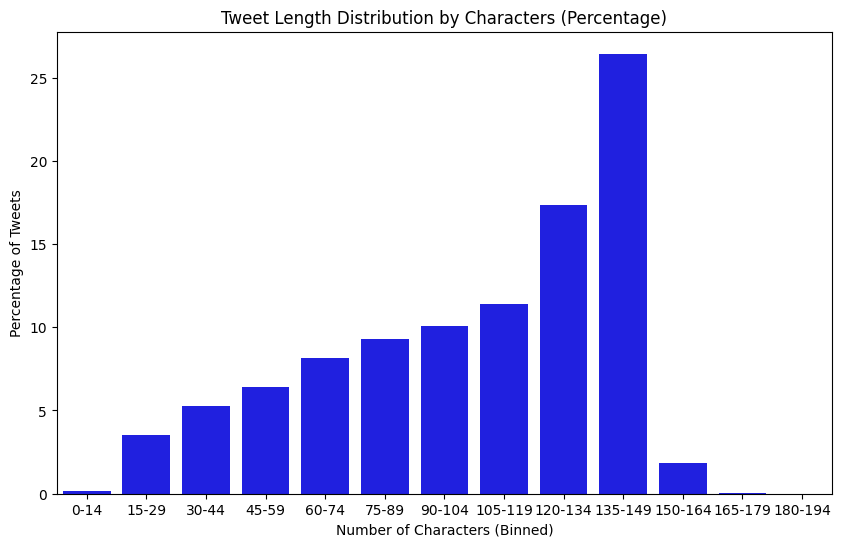

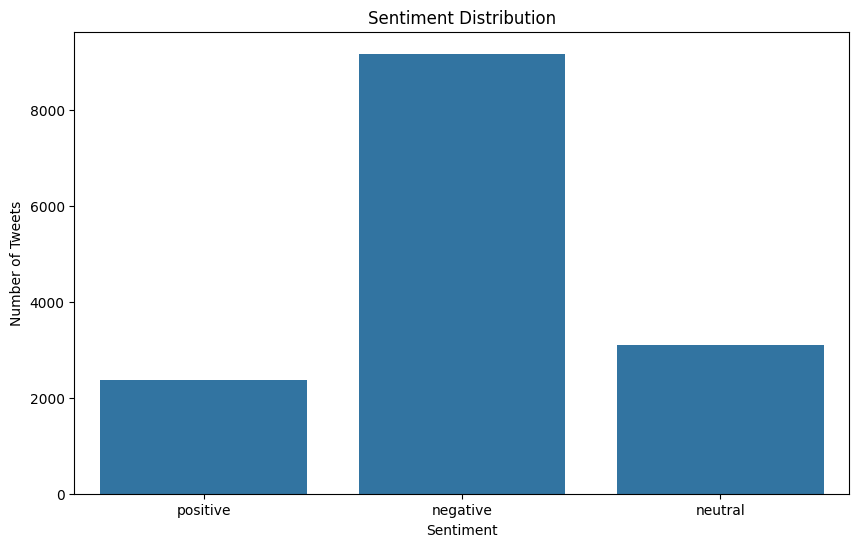

In [10]:


# Character-level Tokenization
tweets_df['char_tokens'] = tweets_df['tweet'].apply(list)

# Character Length Distribution
tweets_df['tweet_length'] = tweets_df['char_tokens'].apply(len)

max_length = tweets_df['tweet_length'].max()
bin_width = 15
bins = np.arange(0, max_length + bin_width, bin_width)
intervals = [f'{i}-{i + bin_width - 1}' for i in bins[:-1]]

tweets_df['length_bin'] = pd.cut(tweets_df['tweet_length'], bins=bins, labels=intervals, right=False)

# Calculate percentages
length_bin_counts = tweets_df['length_bin'].value_counts(normalize=True) * 100
length_bin_counts = length_bin_counts.sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=length_bin_counts.index, y=length_bin_counts.values, color='blue')
plt.title('Tweet Length Distribution by Characters (Percentage)')
plt.xlabel('Number of Characters (Binned)')
plt.ylabel('Percentage of Tweets')
plt.show()

# Sentiment Distribution plot

plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=tweets_df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()



**Emojis**

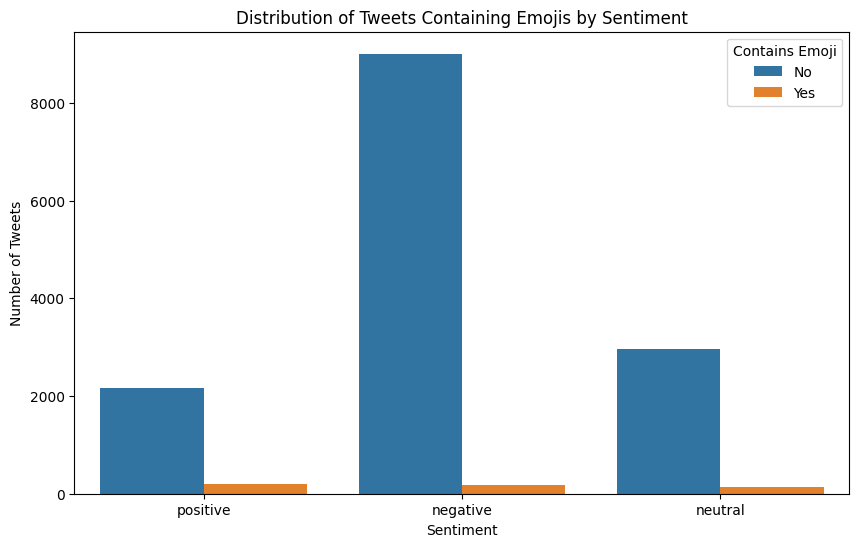

In [11]:
# Extract emojis from each tweet


tweets_df['emojis'] = tweets_df['tweet'].apply(extract_emojis)

# Create a column indicating if the tweet contains at least one emoji
tweets_df['contains_emoji'] = tweets_df['emojis'].apply(lambda x: len(x) > 0)

# Plot the distribution of tweets containing emojis across sentiments
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', hue='contains_emoji', data=tweets_df)
plt.title('Distribution of Tweets Containing Emojis by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.legend(title='Contains Emoji', loc='upper right', labels=['No', 'Yes'])
plt.show()


In [12]:

#number of DISTINCT CHARACTERS in ALL tweets
body=''.join(all_tweets)
len(set(body))

236

In [13]:

emoji_counter=Counter(extract_emojis(body))
emoji_counter


Counter({'🙏': 125,
         '😂': 62,
         '✈': 57,
         '😭': 44,
         '👍': 42,
         '😡': 33,
         '😢': 32,
         '❤': 31,
         '😊': 31,
         '👏': 28,
         '😉': 20,
         '✌': 19,
         '😁': 18,
         '😩': 18,
         '😒': 17,
         '😃': 16,
         '👎': 16,
         '👌': 14,
         '🆘': 14,
         '💙': 13,
         '😄': 12,
         '😔': 11,
         '☺': 10,
         '😍': 10,
         '💔': 10,
         '😕': 9,
         '💗': 8,
         '🎉': 8,
         '❄': 8,
         '😤': 8,
         '🙌': 7,
         '😜': 7,
         '😞': 7,
         '😑': 7,
         '💕': 6,
         '😎': 6,
         '👠': 6,
         '😀': 6,
         '🌴': 6,
         '⭐': 6,
         '🎀': 6,
         '😏': 5,
         '👀': 5,
         '😥': 5,
         '💩': 5,
         '😐': 5,
         '😳': 5,
         '♥': 4,
         '🙅': 4,
         '💯': 4,
         '😘': 4,
         '💺': 4,
         '☀': 4,
         '😫': 4,
         '😖': 4,
         '😠': 4,
         '🍅': 4,
     

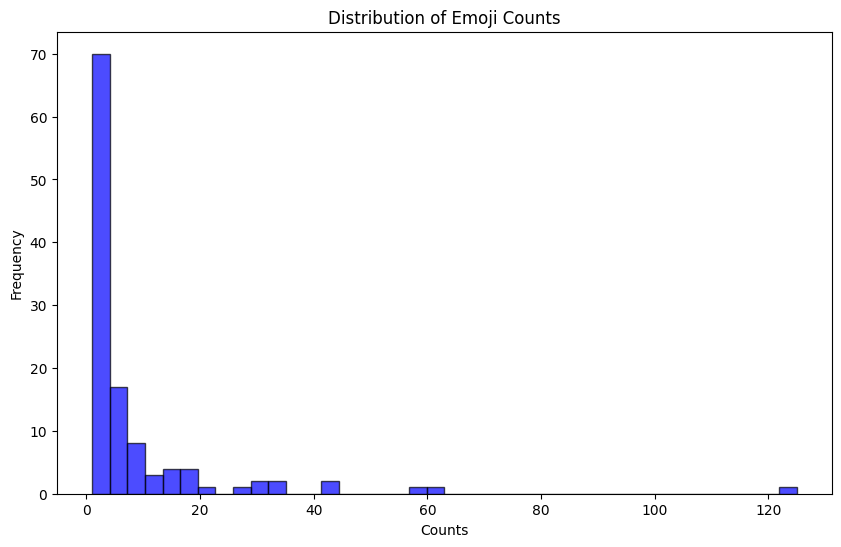

In [14]:
counts = list(emoji_counter.values())

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=40, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Emoji Counts')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.show()

---Comments on emojiis ---

We see that most emojis have scarce appearances in the tweets

Most of them appear less than 4 times in the entire body and there are a lot that appear just once. 

Assuming this distribution is representative of the specific airline tweet's universe, this means that we will probably be getting a lot of unknown emojis in out-of-sample distributions.

Thankfully we will be introducing an UNKNOWN TOKEN character later for tokenization

**Mentions**

In [15]:
set(itertools.chain(*[find_mentions(x)[1:] for x in all_tweets if len(find_mentions(x))>=2]))

{'@0xjared',
 '@10AM',
 '@12am',
 '@2littlebirds',
 '@3',
 '@41CGQueen',
 '@44Stocker',
 '@4geiger',
 '@5',
 '@930',
 '@9NEWS',
 '@AARP',
 '@ABC',
 '@ABC11_WTVD',
 '@ABCNetwork',
 '@ALSTDI',
 '@ALfamilyoffour',
 '@AMiltx3',
 '@ATWOnline',
 '@AUStinAirport',
 '@AUmilo1',
 '@A_Life_Story_',
 '@ActingOutMgmnt',
 '@Active_Aly',
 '@Adam_Karren',
 '@Addair',
 '@AdmiralsClub',
 '@AerocivilCol',
 '@AggieMensGolf',
 '@AirCanada',
 '@AirNZUSA',
 '@AirSouthwest',
 '@AirTahitiNui',
 '@Airbus',
 '@AirlineAdviser',
 '@AirlineGeeks',
 '@AlaskaAir',
 '@AllegiantTravel',
 '@Amagrino',
 '@AmericanAir',
 '@AmericanAirBR',
 '@Analystdoc',
 '@AndrewBiga',
 '@Andrew_Wasila',
 '@AnnetteNaif',
 '@Apollochplayers',
 '@ArminRosen',
 '@AshevilleAir',
 '@AshleyKAtherton',
 '@AskAmex',
 '@AskPayPal',
 '@AuroraBIZ',
 '@Australia',
 '@B787fans',
 '@BA_USA',
 '@BBBNE_SD_KS_IA',
 '@BBB_media',
 '@BDinDallas',
 '@BET',
 '@BRizzyberg27',
 '@BWI',
 '@BWI_Airport',
 '@BarclaycardUS',
 '@BattierCCIpuppy',
 '@Beamske',
 '@B

**Cleaning the data**

In [16]:
#remove excess white spaces, remove urls and remove mentions
tweets_cleaned=[clean_data(x) for x in all_tweets]

In [17]:
tweets_cleaned[:20]

["plus you've added commercials to the experience... tacky.",
 'yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 "Well, I didn't…but NOW I DO! :-D",
 "it was amazing, and arrived an hour early. You're too good to me.",
 'I &lt;3 pretty graphics. so much better than minimal iconography. :D',
 "This is such a great deal! Already thinking about my 2nd trip to  &amp; I haven't even gone on my 1st trip yet! ;p",
 "I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel",
 'Thanks!',
 "So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo",
 'I ❤️ flying . ☺️👍',
 'you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.',
 'I love this graphic.',
 'I love the hipster innovation. You are a feel good brand.',
 'this is great news! America could start flights to Hawaii by end of year  via',
 'Moodlighting is the only way to fly! Best ex

**Splitting cleaned data into train, eval, test sets**

Given the findings above, we perform a stratified split based on a combined feature

In [16]:
#Based on the above discussion, we split all_tweets in train, eval and test sets using a combined feature consisting of the labels and length categories of the tweets.

# Calculate the length of each item in X
lengths = [len(item) for item in all_tweets]

# Create 3 length categories , ie short, medium, long
length_categories = pd.cut(lengths, bins=3, labels=False)

# Create a combined feature by combining labels and length categories
combined_feature = [(label, length_category) for label, length_category in zip(labels, length_categories)]

In [18]:
X_train, X_val, X_test, y_train, y_val, y_test=stratified_train_eval_test_split(all_tweets,labels,combined_feature,eval_test_size=0.2, second_split=0.5, random_state=42)

In [19]:
len(X_train),len(X_val),len(X_test),len(y_train),len(y_val),len(y_test)

(11712, 1464, 1464, 11712, 1464, 1464)

In [29]:
splits = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test
    }

for prefix, data in splits.items():
    os.makedirs(split_folder, exist_ok=True)
    file_path = split_folder / f"{prefix}.txt"
    with open(file_path, 'w', encoding='utf-8') as file:
        for item in data:
            file.write(f"{item}\n")

**Hyperparameter Tuning**

In [ ]:


body=set(''.join(X_train))
vocab_size=len(body)+2##### CHANGE hardcoded 2 to num_special_tokens


hyperparameters = {
  'lr': [0.001,0.002],
  'step_size': [10],
  'gamma': [0.1,0.2],
  'batch_size': [16],
  'd_model': [6],
  'num_encoder_layers': [1,2],
  'n_heads': [2],
  'dim_feedforward': [10],
  'dropout': [0.3],
  'num_epochs': [30],
  'patience': [10]
}
# Convert dictionary to a list of all combinations
param_combinations = [dict(zip(hyperparameters.keys(), values)) for values in product(*hyperparameters.values())]

# Placeholder for dataset

tokenizer=CharacterTokenizer()
tokenizer.fit(body)
num_classes=3


best_params = None
best_val_loss = float('inf')

# Iterate over all combinations of hyperparameters
for params in param_combinations:
    print(f'Training model with parameters {params}')
    # get tunable arguments for each function/class
    dataloader_params = filter_params(DataLoader, params)
    model_params = filter_params(TransformerClassifier, params)
    optimizer_params = filter_params(optim.Adam, params)
    scheduler_params = filter_params(optim.lr_scheduler.StepLR, params)
    train_model_params=filter_params(train_model,params)

    # Prepare DataLoaders

    train_dataloader = create_dataloader(X_train, y_train, tokenizer=tokenizer, **dataloader_params)
    val_dataloader = create_dataloader(X_val, y_val, tokenizer=tokenizer, shuffle=False, drop_last=False,  **dataloader_params)

    # Initialize model with current params
    model = TransformerClassifier(vocab_size=vocab_size, num_classes=num_classes,**model_params)

    # Set up optimizer and scheduler with current lr and gamma
    optimizer = optim.Adam(model.parameters(),**optimizer_params)
    scheduler = StepLR(optimizer, **scheduler_params)

    criterion = nn.CrossEntropyLoss()

    # Train the model
    train_loss,val_loss= train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, save_path='output/hparam_result/best_model.pt',**train_model_params)
    # Update best parameters if current model is better
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params

    print(f"Best Validation Loss: {best_val_loss}")
    print(f"Best Hyperparameters: {best_params}")
    save_best_params(best_params, hparameter_output_path)

In [38]:
from utilities.save_load import read_labels_from_folder,read_list_from_folder,load_model
from utilities.tokenizers import CharacterTokenizer
import torch
import json
tokenizer = CharacterTokenizer()  # Load or initialize your tokenizer
model_path='output/eval_result/best_model.pt'
best_params_path='output/hparam_result/best_params.json'
X_train = read_list_from_folder('./data/split', 'X_train')
y_train = read_labels_from_folder('./data/split', 'y_train')
X_val = read_list_from_folder('./data/split', 'X_val')
y_val = read_labels_from_folder('./data/split', 'y_val')
X_train_val=X_train+X_val
y_train_val=y_train+y_val

with open(best_params_path, 'r') as file:
    best_params = json.load(file)
best_params

{'lr': 0.002,
 'step_size': 10,
 'gamma': 0.1,
 'batch_size': 16,
 'd_model': 6,
 'num_encoder_layers': 2,
 'n_heads': 2,
 'dim_feedforward': 10,
 'dropout': 0.3,
 'num_epochs': 30,
 'patience': 10}

In [40]:
from model import TransformerClassifier
from hparam_tuning_eval import filter_params
body=set((''.join(X_train_val)))
tokenizer.fit(body)
vocab_size=len(body)+2 
num_classes=3
model_params = filter_params(TransformerClassifier, best_params)
model_params



{'d_model': 6,
 'num_encoder_layers': 2,
 'n_heads': 2,
 'dim_feedforward': 10,
 'dropout': 0.3}

In [42]:
model = TransformerClassifier(vocab_size=vocab_size, num_classes=num_classes,**model_params)
model


TransformerClassifier(
  (embedding): Embedding(236, 6)
  (pos_encoder): PositionalEncoding()
  (encoder_layers): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
    )
    (linear1): Linear(in_features=6, out_features=10, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (linear2): Linear(in_features=10, out_features=6, bias=True)
    (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (dropout2): Dropout(p=0.3, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
        )
        (linear1): Linear(in_features=6, out_features=10, bias=Tr

In [43]:
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [44]:
model.eval()

TransformerClassifier(
  (embedding): Embedding(236, 6)
  (pos_encoder): PositionalEncoding()
  (encoder_layers): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
    )
    (linear1): Linear(in_features=6, out_features=10, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (linear2): Linear(in_features=10, out_features=6, bias=True)
    (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (dropout2): Dropout(p=0.3, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
        )
        (linear1): Linear(in_features=6, out_features=10, bias=Tr

In [45]:
tokens=tokenizer.encode('What a nice day today!! I am going out for a walk')

input_tensor = torch.tensor([tokens], dtype=torch.long)  # Assuming the model expects batch first
src_key_padding_mask = (input_tensor == tokenizer._token_to_id[tokenizer.pad_token])  # Assuming you have a PAD token


In [46]:
input_tensor

tensor([[55, 70, 63, 82,  2, 63,  2, 76, 71, 65, 67,  2, 66, 63, 87,  2, 82, 77,
         66, 63, 87,  3,  3,  2, 41,  2, 63, 75,  2, 69, 77, 71, 76, 69,  2, 77,
         83, 82,  2, 68, 77, 80,  2, 63,  2, 85, 63, 74, 73]])

In [47]:
output = model(input_tensor, src_key_padding_mask=src_key_padding_mask)
pred = torch.argmax(output, dim=1)

In [48]:
pred

tensor([1])

In [32]:
from model import TransformerClassifier
from utilities.save_load import read_labels_from_folder,read_list_from_folder
from utilities.tokenizers import CharacterTokenizer
import torch
from hparam_tuning_eval import filter_params

import json


tokenizer = CharacterTokenizer()  # Load or initialize your tokenizer
model_path='output/eval_result/best_model.pt'
best_params_path='output/hparam_result/best_params.json'
X_train = read_list_from_folder('./data/split', 'X_train')
y_train = read_labels_from_folder('./data/split', 'y_train')
X_val = read_list_from_folder('./data/split', 'X_val')
y_val = read_labels_from_folder('./data/split', 'y_val')
X_train_val=X_train+X_val
y_train_val=y_train+y_val

body=set((''.join(X_train_val)))
tokenizer.fit(body)
vocab_size=len(body)+2 
num_classes=3

with open(best_params_path, 'r') as file:
    best_params = json.load(file)
model_params = filter_params(TransformerClassifier, best_params)
model_params


{'d_model': 6,
 'num_encoder_layers': 2,
 'n_heads': 2,
 'dim_feedforward': 10,
 'dropout': 0.3}

In [33]:
def load_model(model_path):
    # Assuming model_config is predefined or retrieved from a reliable source
    model = TransformerClassifier(vocab_size=vocab_size, num_classes=num_classes,**model_params)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set to evaluation mode to disable dropout and batch normalization
    return model

In [34]:
def predict(model, input_lines, tokenizer,batch_size=2):
    predictions = []
    with torch.no_grad():
        for i in range(0, len(input_lines), batch_size):
            batch = input_lines[i:i+batch_size]
            tokenized = [tokenizer.encode(line) for line in batch]
            # Create a padded tensor for the batch
            padded = torch.nn.utils.rnn.pad_sequence([torch.tensor(tokens) for tokens in tokenized],
                                                     batch_first=True, padding_value=tokenizer._token_to_id[tokenizer.pad_token])
            # Create a mask where padding tokens are True (masked) and all others are False (unmasked)
            src_key_padding_mask = (padded == tokenizer._token_to_id[tokenizer.pad_token])
            
            output = model(padded, src_key_padding_mask)
            preds = torch.argmax(output, dim=1).tolist()  # Get predicted class indices for the whole batch
            predictions.extend(preds)
    return predictions


In [35]:
model=load_model(model_path=model_path)
input_lines=['I am going to the supermarke#grocery','@Who let the dogs out man?!! ', 'Did you go out at all???????','Anybody home?@@@ who is there??S']+[
    "Wow, what a fantastic game last night! 🎉🎉 #Victory",
    "I'm not sure why I expected more from that movie. 😕 #disappointed",
    "Absolutely love my new headphones! 😍🎧 #BestPurchase",
    "Could today get any worse? 😢 It just keeps raining non-stop! ☔️",
    "Check out this awesome throwback! 👾🕹️ #RetroGaming",
    "Never going back to that restaurant again. Worst service ever! 😡👎",
    "Just finished reading 'The Great Gatsby'... mind blown! 📚💥",
    "Ugh, Monday mornings are the worst, right? 😴🙅‍♂️ #mondayblues",
    "Who else loves the smell of fresh coffee in the morning? ☕️😊 #coffeeaddict",
    "Traffic today was a nightmare! Stuck for over an hour. 🚗🚕🚙 #trafficjam"
]

predict(model,input_lines,tokenizer=tokenizer)

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:179.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


[0, 1, 2, 2, 0, 1, 1, 2, 0, 0, 1, 1, 2, 0]

In [17]:
tokenizer1 = CharacterTokenizer()  # Load or initialize your tokenizer

body=set((''.join(X_train_val)))
tokenizer1.fit(body)
tokenizer1.save('test_tokenizer.json')

In [18]:
tokenizer1.load('test_tokenizer.json')

In [19]:
encoded_sentence = tokenizer1.encode("Example sentence here")
encoded_sentence

[37,
 86,
 63,
 75,
 78,
 74,
 67,
 2,
 81,
 67,
 76,
 82,
 67,
 76,
 65,
 67,
 2,
 70,
 67,
 80,
 67]

In [20]:
tokenizer1.vocab_size

236

In [21]:
tokenizer2=CharacterTokenizer()
tokenizer2.load('output/eval_result/trained_tokenizer.json')
encoded_sentence = tokenizer2.encode("Example sentence here")
print(encoded_sentence)

[37, 86, 63, 75, 78, 74, 67, 2, 81, 67, 76, 82, 67, 76, 65, 67, 2, 70, 67, 80, 67]


In [28]:
tokenizer2.vocab_size

236